<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-04-03-02-multilevel-glm-multinomial-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.2. Multilevels or Mixed-Effects Multinomial Model

Multilevels or Mixed-Effect miltinomial model is an extension of the multinomial regression model that accounts for random effects. It's particularly useful when data is structured hierarchically or has a multilevel nature, such as repeated measurements within individuals or groups. In this tutorial, we will demonstrate how to build and fit a multilevel multinomial model in R, focusing on the theoretical background, model implementation, and interpretation of results.

## Overview

Multilevel multinomial models, also known as mixed-effects multinomial models, are used to analyze categorical outcomes with more than two categories while accounting for hierarchical structures in the data. These models extend the concept of mixed-effects models to multinomial outcomes, allowing for the estimation of both fixed and random effects. By incorporating random effects, these models can capture the variability within groups or clusters, providing more accurate estimates and predictions. In this tutorial, we will demonstrate how to build and fit a multilevel multinomial model in R, focusing on the theoretical background, model implementation, and interpretation of results.

A **Mixed-Effects Multinomial Regression Model** is an extension of the multinomial regression model that accounts for random effects. It's particularly useful when data is structured hierarchically or has a multilevel nature, such as repeated measurements within individuals or groups.

Below, I explain the model, starting with multinomial regression, then incorporating mixed effects.

**1. Multinomial Regression**

Multinomial regression models the probabilities of $K$ categorical outcomes ($y$) for a dependent variable, given predictors $\mathbf{X}$. For $K$-category outcomes ($y \in \{1, 2, \dots, K\}$):

$$ P(y = k \mid \mathbf{X}) = \frac{\exp(\boldsymbol{\beta}_k^\top \mathbf{X})}{\sum_{j=1}^K \exp(\boldsymbol{\beta}_j^\top \mathbf{X})}, \quad k = 1, 2, \dots, K $$

-   $\boldsymbol{\beta}_k$: Coefficients for the predictors for category $k$.
-   One category (often the last one) is treated as the **reference category**, and its coefficients $\boldsymbol{\beta}_K$ are set to 0 to avoid overparameterization.

The log-odds of being in category $k$ relative to the reference category $K$ is:

$$ \log \left( \frac{P(y = k \mid \mathbf{X})}{P(y = K \mid \mathbf{X})} \right) = \boldsymbol{\beta}_k^\top \mathbf{X} $$

**2. Mixed-Effects Multinomial Regression**

To incorporate random effects, the model adds random components to account for variability across clusters or groups (e.g., individuals, locations). The random effects modify the linear predictor.

For each cluster $i$, we assume:

$$ P(y_i = k \mid \mathbf{X}_i, \mathbf{b}_i) = \frac{\exp((\boldsymbol{\beta}_k + \mathbf{b}_{i,k})^\top \mathbf{X}_i)}{\sum_{j=1}^K \exp((\boldsymbol{\beta}_j + \mathbf{b}_{i,j})^\top \mathbf{X}_i)}, \quad k = 1, 2, \dots, K $$

-   $\mathbf{b}_{i,k}$: Random effects for group $i$ and category $k$.
-   $\mathbf{b}_i = (\mathbf{b}_{i,1}, \dots, \mathbf{b}_{i,K})$ are typically assumed to follow a multivariate normal distribution:
-   $\mathbf{b}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{\Sigma})$, where $\mathbf{\Sigma}$ is the covariance matrix of random effects.

The random effects allow the model to capture unobserved heterogeneity across groups.



**Model Interpretation**

-   **Fixed Effects**: Represent the population-level relationships between predictors and the outcome probabilities.
-   **Random Effects**: Capture deviations specific to each cluster or group.
-   The probabilities for each category are obtained by combining fixed and random effects in the linear predictor.

**Log-Likelihood Function**

The log-likelihood for the mixed-effects multinomial model, given data ($\mathbf{y}, \mathbf{X}$), is:

$$ \mathcal{L}(\boldsymbol{\beta}, \mathbf{\Sigma}) = \sum_{i=1}^N \log \int \prod_{j=1}^{n_i} P(y_{ij} \mid \mathbf{X}_{ij}, \mathbf{b}_i) f(\mathbf{b}_i \mid \mathbf{\Sigma}) , d\mathbf{b}_i, $$

where:

-   $n_i$: Number of observations in group $i$.
-   $f(\mathbf{b}\_i \mid \mathbf{\Sigma})$: Density of the random effects.

This integral is generally intractable, so numerical methods such as **Gaussian quadrature** or **Monte Carlo integration** are used.

Suppose we want to model a patient's choice among three treatments ($A, B, C$) repeatedly observed across multiple hospitals. Predictor variables include patient characteristics ($\mathbf{X}_{ij}$), and random effects account for variability in hospital-level preferences.

-   Fixed effects: ($\boldsymbol{\beta}$) capture how predictors like age or severity influence treatment choice.
-   Random effects: ($\mathbf{b}_i$) allow each hospital to have its own baseline tendencies for treatment preferences.

The model estimates how patient characteristics and hospital preferences jointly influence treatment choices, providing insights into the factors driving patient decisions.


## Install rpy2

In [2]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314975 sha256=4ebc26b9d9fb6342b85b656fa4059d46b71bdca850d9302d5eaf245e761c80cf
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Multilevel Multinomial Model from Scratch

Building a multilevel multinomial logistic regression model from scratch in R without using specialized packages is a complex task because it involves implementing maximum likelihood estimation, handling the integration over random effects, and ensuring numerical stability. Below is a step-by-step outline for such an implementation:

### Generate Example Data

We’ll create synthetic data with both fixed and random effects for a multinomial outcome. The data will include a single predictor variable and group identifiers for the random effects. The design matrix will include an intercept term.

In [4]:
%%R
# Set seed for reproducibility
set.seed(123)

# Simulate Example Data
set.seed(42)
n <- 100  # Number of observations
n_groups <- 5  # Number of groups
X <- data.frame(X1 = rnorm(n))  # Single predictor
group <- sample(1:n_groups, n, replace = TRUE)  # Group identifiers
y <- sample(1:3, n, replace = TRUE)  # Multinomial outcome (3 categories)
data <- data.frame(group = group, X1 = X$X1, y = y)

# Design matrix including intercept
X <- cbind(1, as.matrix(data[, "X1", drop = FALSE]))  # Add intercept
# Initial parameter vector (length should match model requirements)
num_predictors <- ncol(X)  # Including intercept
num_categories <- length(unique(data$y))
init_params <- c(rep(0, num_predictors * (num_categories - 1)), log(1))

head(data)

  group         X1 y
1     2  1.3709584 3
2     1 -0.5646982 2
3     4  0.3631284 2
4     3  0.6328626 1
5     5  0.4042683 3
6     2 -0.1061245 3


### Define the multinomial log-likelihood with random effects

The log-likelihood function calculates the negative log-likelihood of the model given the data, parameters, and random effects. It integrates over the random effects using Gaussian quadrature to estimate the log-likelihood for each group. The function also includes a regularization term to prevent large random effect variances.  

In [5]:
%%R
#  Define the multinomial log-likelihood with random effects
log_likelihood <- function(params, data, groups, X, y) {
  # Number of predictors (including intercept)
  num_predictors <- ncol(X)
  # Number of categories
  num_categories <- length(unique(y))
  # Reshape beta parameters
  beta <- matrix(params[1:(num_predictors * (num_categories - 1))],
                 nrow = num_predictors,
                 ncol = (num_categories - 1))
  # Random effect variance (with regularization to prevent divergence)
  sigma <- exp(params[(num_predictors * (num_categories - 1)) + 1])

  # Small value to avoid log(0) and division by zero
  epsilon <- 1e-10
  regularization_penalty <- 1e-4  # Regularization term for sigma to avoid large variances

  logL <- 0  # Initialize log-likelihood

  # Loop over groups
  for (g in unique(groups)) {
    group_data <- data[groups == g, ]
    group_X <- X[groups == g, , drop = FALSE]  # Ensure group_X is a matrix
    group_y <- y[groups == g]

    # Ensure group_X has the same number of columns as beta rows
    if (ncol(group_X) != nrow(beta)) {
      stop("Dimension mismatch: group_X and beta are not conformable!")
    }

    # Integrate over random effects (using Gaussian quadrature)
    b_vals <- seq(-3 * sigma, 3 * sigma, length.out = 10)  # Integration grid
    integrand <- sapply(b_vals, function(b) {
      lin_pred <- group_X %*% beta + b
      exp_lin_pred <- exp(lin_pred)
      pred_probs <- exp_lin_pred / rowSums(exp_lin_pred)  # Normalize to get probabilities

      # Clip probabilities to avoid issues with log(0) or log(1)
      pred_probs <- pmax(pmin(pred_probs, 1 - epsilon), epsilon)

      # Map group_y values (1, 2, 3) to 1, 2 for indexing pred_probs
      valid_group_y <- pmin(group_y, num_categories - 1)  # Map 3 to 2

      # Log-probability for observations
      log_prob <- sum(log(pred_probs[cbind(1:nrow(group_data), valid_group_y)]))
      dnorm(b, mean = 0, sd = sigma, log = TRUE) + log_prob
    })

    # Aggregate log-likelihood
    logL <- logL + log(sum(exp(integrand)))
  }

  # Add regularization term to prevent large sigma
  logL <- logL - regularization_penalty * sigma^2

  return(-logL)  # Return negative log-likelihood for optimization
}


### Optimization and  Fit the Model

Optimize the log-likelihood function to estimate the model parameters. We used `Nelder-Mead` optimization method was used. This methods is often more stable when dealing with noisy or numerically unstable functions. The optimization process is controlled by the maximum number of iterations and the level of output tracing.


In [6]:
%%R
fit <- optim(
  par = init_params,
  fn = log_likelihood,
  data = data,
  groups = data$group,
  X = X,  # Pass design matrix with intercept
  y = data$y,
  method = "Nelder-Mead",  # Using a more stable optimization method
  control = list(trace = 1, maxit = 100)
)


  Nelder-Mead direct search function minimizer
function value for initial parameters = 67.290928
  Scaled convergence tolerance is 1.00271e-06
Stepsize computed as 0.100000
BUILD              6 69.315876 65.515876
EXTENSION          8 67.790950 63.493572
LO-REDUCTION      10 67.596756 63.493572
LO-REDUCTION      12 67.290928 63.493572
EXTENSION         14 67.253382 61.472161
EXTENSION         16 65.515876 59.987946
LO-REDUCTION      18 64.433890 59.987946
LO-REDUCTION      20 63.978613 59.987946
LO-REDUCTION      22 63.493572 59.987946
LO-REDUCTION      24 61.472161 59.832577
LO-REDUCTION      26 60.414464 59.832577
EXTENSION         28 60.291692 59.481949
LO-REDUCTION      30 60.106304 59.481949
EXTENSION         32 59.987946 59.327386
LO-REDUCTION      34 59.961911 59.327386
EXTENSION         36 59.832577 58.751213
LO-REDUCTION      38 59.778740 58.751213
EXTENSION         40 59.482787 58.449349
LO-REDUCTION      42 59.481949 58.449349
LO-REDUCTION      44 59.370115 58.449349
EXTENSI

### Output Results

Other results such as the optimized parameters, final log-likelihood, and convergence status are extracted from the optimization output.

In [7]:
%%R
# Output Results
print(fit$par)      # Optimized parameters
print(-fit$value)   # Final log-likelihood
print(fit$convergence)  # Convergence status (0 = success)

[1]  13.842317   6.149148  13.000008   3.977466 -35.862473
[1] 40.25179
[1] 1


### Model Evaluation

The estimated beta coefficients and random effect variance are extracted from the optimized parameters for model evaluation.  

In [8]:
%%R
# Evaluate Model
beta_hat <- matrix(fit$par[1:(num_predictors * (num_categories - 1))],
                   nrow = num_predictors,
                   ncol = (num_categories - 1))
sigma_hat <- exp(fit$par[(num_predictors * (num_categories - 1)) + 1])

cat("\nEstimated Beta Coefficients:\n")
print(beta_hat)

cat("\nEstimated Random Effect Variance (Sigma):\n")
print(sigma_hat)


Estimated Beta Coefficients:
          [,1]      [,2]
[1,] 13.842317 13.000008
[2,]  6.149148  3.977466

Estimated Random Effect Variance (Sigma):
[1] 2.661495e-16


### Make Predictions Using the Fitted Model

Predict the class labels for each observation based on the estimated parameters. The predicted probabilities are calculated using the linear predictor and normalized to obtain class probabilities. The class with the highest probability is assigned as the predicted class label.  

In [9]:
%%R
predict_multilevel <- function(fit, data, X, num_categories) {
  # Extract the parameters from the fit object
  beta <- matrix(fit$par[1:(ncol(X) * (num_categories - 1))], ncol = (num_categories - 1))
  sigma <- exp(fit$par[(ncol(X) * (num_categories - 1)) + 1])  # Random effect variance

  # Predicted probabilities for each class
  pred_probs <- matrix(0, nrow = nrow(X), ncol = num_categories)

  # Loop through the rows of the data to calculate probabilities
  for (i in 1:nrow(X)) {
    # Compute linear predictor (with random effect b = 0 for simplicity)
    lin_pred <- X[i, , drop = FALSE] %*% beta
    exp_lin_pred <- exp(lin_pred)
    pred_probs[i, 1:(num_categories - 1)] <- exp_lin_pred / rowSums(exp_lin_pred)  # Normalize to get probabilities

    # The probability for the reference category (num_categories)
    pred_probs[i, num_categories] <- 1 - sum(pred_probs[i, 1:(num_categories - 1)])
  }

  # Convert probabilities to predicted class labels (the class with the highest probability)
  predicted_classes <- apply(pred_probs, 1, which.max)

  return(predicted_classes)
}

# Make predictions on the training data
predicted_classes <- predict_multilevel(fit, data, X, num_categories = 3)

# Evaluate the model performance
conf_matrix <- table(Predicted = predicted_classes, Actual = data$y)

# Print confusion matrix
print(conf_matrix)

# Calculate accuracy
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
print(paste("Accuracy:", round(accuracy, 4)))

         Actual
Predicted  1  2  3
        1 19 22 28
        2 12 15  4
[1] "Accuracy: 0.34"


## Multilevel Multinomial Model in R

In this section, we will focus on how to implement a mixed-effects multinomial regression model using the `mblogit()` function from the {mclogit} package in R. The `mblogit()` function allows you to fit multinomial models with random effects, making it suitable for analyzing categorical outcomes with hierarchical structures. We will demonstrate the step-by-step process of building and interpreting a mixed-effects multinomial model using the `mblogit()` function.

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:




In [10]:
%%R
packages <- c('tidyverse',
              'DataExplorer',
              'sjPlot',
              'margins',
              'performance',
              'mclogit'
		 )

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages('mclogit', lib='drive/My Drive/R/')

In [13]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
   tidyverse DataExplorer       sjPlot      margins  performance      mclogit 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 


### Load R Packages

In [14]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages


Successfully loaded packages:
 [1] "package:mclogit"      "package:Matrix"       "package:performance" 
 [4] "package:margins"      "package:sjPlot"       "package:DataExplorer"
 [7] "package:lubridate"    "package:forcats"      "package:stringr"     
[10] "package:dplyr"        "package:purrr"        "package:readr"       
[13] "package:tidyr"        "package:tibble"       "package:ggplot2"     
[16] "package:tidyverse"    "package:tools"        "package:stats"       
[19] "package:graphics"     "package:grDevices"    "package:utils"       
[22] "package:datasets"     "package:methods"      "package:base"        


### Data

In this exercise we will use  use a synthatic data similar to `Transport` data set of {mclogit} package. The dataset contains information about the mode of transportation chosen by individuals based on the cost, working population, and distance traveled. The goal is to predict the mode of transportation based on these predictors using a mixed-effects multinomial model.

`transport`: The chosen mode of transportation (Car, Bus, Train).
`cost`: Cost of the transportation, influenced by distance and suburb class.
`working`: Size of the working population in the suburb.
`distance`: Distance traveled, uniformly distributed between 1 km and 50 km.
`suburb`: Categorical variable indicating the suburb class (A, B, C, D).



In [15]:
%%R
# Load required package
set.seed(123)  # For reproducibility

# Define constants
n_samples <- 1000
suburb_classes <- c("A", "B", "C", "D")
transport_modes <- c("Car", "Bus", "Train")
n_suburbs <- length(suburb_classes)

# Generate suburb data
suburbs <- sample(suburb_classes, size = n_samples, replace = TRUE, prob = c(0.2, 0.3, 0.3, 0.2))

# Generate working population size by suburb class
working_population_by_class <- list(
  A = c(mean = 200, sd = 50),
  B = c(mean = 150, sd = 30),
  C = c(mean = 100, sd = 20),
  D = c(mean = 50, sd = 15)
)
working_population <- sapply(suburbs, function(suburb) {
  rnorm(1, mean = working_population_by_class[[suburb]]["mean"],
        sd = working_population_by_class[[suburb]]["sd"])
})

# Generate distance traveled (longer distances in suburban/rural areas)
distance <- runif(n_samples, min = 1, max = 50)  # Between 1 km and 50 km

# Generate cost (correlated with distance and suburb class)
cost_base_by_class <- c(A = 2.0, B = 1.8, C = 1.5, D = 1.2)
cost <- mapply(function(suburb, dist) {
  dist * rnorm(1, mean = cost_base_by_class[suburb], sd = 0.2)
}, suburb = suburbs, dist = distance)

# Simulate multinomial choice for transport modes
# Use a softmax-like function for transport probabilities
softmax <- function(x) {
  exp_x <- exp(x - max(x))
  exp_x / sum(exp_x)
}

# Assign base utilities for transport modes by suburb
base_utilities <- list(
  Car = c(A = 2.5, B = 2.0, C = 1.5, D = 1.0),
  Bus = c(A = 1.5, B = 1.8, C = 2.0, D = 2.5),
  Train = c(A = 2.0, B = 1.5, C = 1.2, D = 1.0)
)

# Calculate probabilities and assign transport
transport_choices <- sapply(1:n_samples, function(i) {
  utilities <- sapply(transport_modes, function(mode) {
    base_utilities[[mode]][suburbs[i]] - 0.05 * cost[i] + 0.02 * distance[i]
  })
  probabilities <- softmax(utilities)
  sample(transport_modes, size = 1, prob = probabilities)
})

# Create the final dataset
mf <- data.frame(
  transport = transport_choices,
  cost = cost,
  working = working_population,
  distance = distance,
  suburb = suburbs
)
# convert to factor
mf$transport <- as.factor(mf$transport)
mf$suburb <- as.factor(mf$suburb)
# Preview the dataset
glimpse(mf)

Rows: 1,000
Columns: 5
$ transport <fct> Bus, Bus, Bus, Train, Car, Bus, Bus, Bus, Train, Bus, Car, C…
$ cost      <dbl> 18.819656, 58.857251, 27.258692, 71.097966, 20.331215, 55.84…
$ working   <dbl> 131.94321, 35.09452, 120.53570, 237.55307, 124.54167, 147.14…
$ distance  <dbl> 11.085519, 47.184413, 19.586866, 31.685767, 9.991618, 33.301…
$ suburb    <fct> B, D, C, A, A, B, C, A, C, C, A, C, D, C, B, A, B, B, C, A, …


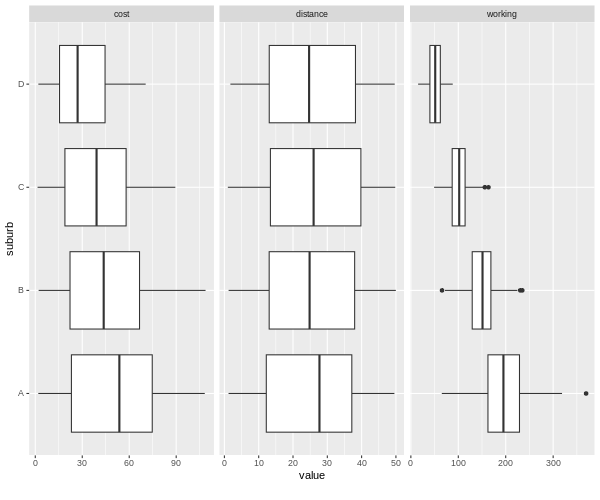

In [16]:
%%R -w 600 -h 500 -u px
mf  |>
  dplyr::select(cost, working, distance, suburb)  |>
  DataExplorer::plot_boxplot(by = 'suburb')

### Fit a Multilevel Multinomial Model

We will fit a mixed-effects multinomial model to the `Transport` dataset using the `mblogit()` function from the {mclogit} package. The model will predict the choice of transportation based on the cost, walking distance, and working population of each suburb. We will include random effects for the `suburb` variable to account for the hierarchical structure of the data.


#### Random Intercept Model

In a first step, we generate a baseline model with random intercept only. This model assumes that the effect of the predictors is the same across all levels of the random effect.  



In [19]:
%%R
# Fit random intercept multinomial model
model_inter <- mblogit(formula = transport ~ 1,
              random = ~ 1 | suburb,
              data = mf)


Iteration 1 - deviance = 2018.42 - criterion = 1.18739


Iteration 2 - deviance = 2019.28 - criterion = 0.01534171


Iteration 3 - deviance = 2019.471 - criterion = 1.05413e-05


Iteration 4 - deviance = 2019.468 - criterion = 2.19327e-11
converged


In [20]:
%%R
summary(model_inter)


Call:
mblogit(formula = transport ~ 1, data = mf, random = ~1 | suburb)

Equation for Car vs Bus:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.1552     0.3993  -0.389    0.697

Equation for Train vs Bus:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -0.7218     0.3415  -2.114   0.0345 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Co-)Variances:
Grouping level: suburb 
        Estimate        Std.Err.     
Car~1   0.6133          0.3349       
Train~1 0.4989 0.4334   0.2799 0.2339

Approximate residual deviance: 2019 
Number of Fisher scoring iterations:  4
Number of observations
  Groups by suburb: 4
  Individual observations:  1000


#### Mixed-Effects Multinomial Model

We will fit a mixed-effects multinomial model with random intercept allowing the effect of the predictors to vary across levels of the random effect.    


In [21]:
%%R
# Fit random intercept and slope multinomial model
model_mixed <- mblogit(formula = transport ~ cost + working + distance,
              random = ~ 1 | suburb,
              data = mf)


Iteration 1 - deviance = 2020.804 - criterion = 1.179956


Iteration 2 - deviance = 2017.311 - criterion = 0.01854146


Iteration 3 - deviance = 2017.514 - criterion = 1.66178e-05


Iteration 4 - deviance = 2017.509 - criterion = 9.349468e-11
converged


In [22]:
%%R
summary(model_mixed)


Call:
mblogit(formula = transport ~ cost + working + distance, data = mf, 
    random = ~1 | suburb)

Equation for Car vs Bus:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.314057   0.487163  -0.645    0.519
cost        -0.002346   0.010427  -0.225    0.822
working      0.001417   0.002365   0.599    0.549
distance     0.003019   0.017704   0.171    0.865

Equation for Train vs Bus:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept) -1.152709   0.421166  -2.737   0.0062 **
cost         0.005934   0.011392   0.521   0.6024   
working      0.002561   0.002344   1.092   0.2747   
distance    -0.005541   0.019596  -0.283   0.7774   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Co-)Variances:
Grouping level: suburb 
        Estimate        Std.Err.       
Car~1   0.5117          0.13468        
Train~1 0.3213 0.2239   0.08724 0.05652

Approximate residual deviance: 2018 
Number of Fisher scoring iterations:  4
Number of observations


#### Model Comparison

We can compare the two models using the `anova()` function to see if the mixed-effects model provides a better fit to the data than the random intercept model.  


In [23]:
%%R
anova(model_inter, model_mixed)

Analysis of Deviance Table

Model 1: transport ~ 1
Model 2: transport ~ cost + working + distance
  Resid. Df Resid. Dev Df Deviance
1      1995     2019.5            
2      1989     2017.5  6   1.9592


As the second model is significantly better, we are justified to believe that our fixed effects have explanatory power. We can now use the `getSummary.mmblogit()` function to get a summary of the model with the fixed effects.

In [24]:
%%R
getSummary.mmblogit(model_mixed)

$coef
, , Car/Bus

                     est          se       stat         p          lwr
(Intercept) -0.314056911 0.487163046 -0.6446649 0.5191444 -1.268878937
cost        -0.002345802 0.010426949 -0.2249749 0.8219988 -0.022782247
working      0.001416738 0.002365095  0.5990195 0.5491599 -0.003218763
distance     0.003018856 0.017703536  0.1705228 0.8645990 -0.031679437
                    upr
(Intercept) 0.640765114
cost        0.018090643
working     0.006052239
distance    0.037717149

, , Train/Bus

                     est          se       stat          p          lwr
(Intercept) -1.152708724 0.421165825 -2.7369474 0.00620122 -1.978178572
cost         0.005933943 0.011391700  0.5209006 0.60243601 -0.016393379
working      0.002560673 0.002344172  1.0923572 0.27467615 -0.002033819
distance    -0.005541115 0.019596485 -0.2827607 0.77736030 -0.043949521
                     upr
(Intercept) -0.327238876
cost         0.028261266
working      0.007155164
distance     0.032867290


$su

We can also use the `tab_model()` function from the {sjPlot} package to generate a table of the model coefficients and their significance levels. Each row in the table represents a predictor variable, and the columns display `Odds Ratios`, `CI`, and `p-values`.  


In [26]:
%%R
sjPlot::tab_model(model_mixed)


Plot the marginal effects of the predictors on the outcome variable using the `plot_model()` function from the {sjPlot} package. This function generates a plot showing the marginal effects of each predictor variable on the outcome variable, along with confidence intervals.  

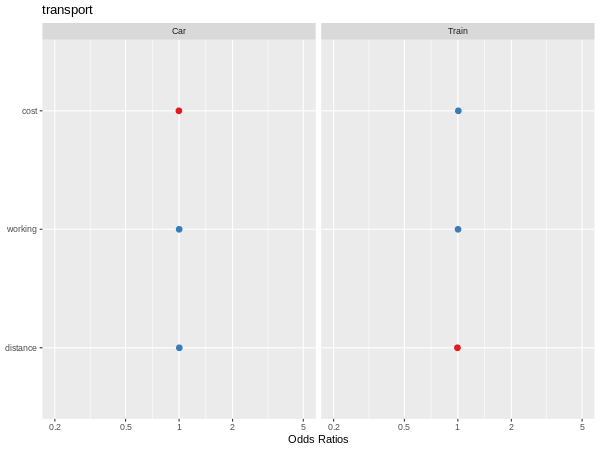

In [28]:
%%R -w 600 -h 450 -u px
# Plot marginal effects
sjPlot::plot_model(model_mixed)

#### Model Performance

We can evaluate the performance of the mixed-effects multinomial model using the `performance()` function from the {performance} package. This function provides various performance metrics such as the AIC, BIC, and log-likelihood of the model.



In [29]:
%%R
performance::performance(model_mixed)

# Indices of model performance

AIC      |      BIC | Nagelkerke's R2 |  RMSE | Sigma
-----------------------------------------------------
2039.509 | 2093.494 |           0.185 | 0.447 | 1.426


####  Prediction Performance

We can also evaluate the prediction performance of the model using the `predict()` function. This function generates predicted probabilities for each category of the outcome variable based on the model's fixed and random effects.  

In [30]:
%%R
# Predict probabilities for each category
pred_probs <- predict(model_mixed, type = "response")
# # Convert probabilities to class
pred_classes <- apply(pred_probs, 1, which.max)
head(pred_classes)

[1] 2 1 1 2 2 2


In [31]:
%%R
# Training set evaluation
actual_classes <- as.numeric(mf$transport)
# Convert to numeric if needed
conf_matrix <- table(Predicted = pred_classes, Actual = actual_classes)
conf_matrix

         Actual
Predicted   1   2   3
        1 287 143  81
        2 148 223 118


In [32]:
%%R
# accuracy
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
accuracy

[1] 0.51


In-class Accuracy or Per-class Accuracy:

In [33]:
%%R
# Calculate in-class accuracy
in_class_accuracy <- diag(conf_matrix) / colSums(conf_matrix)

# Display in-class accuracy for each class
cat("In-Class Accuracy for each class:\n")
print(round(in_class_accuracy* 100, 2))

In-Class Accuracy for each class:
     1      2      3 
 65.98  60.93 144.22 


## Summary and Concusion

This tutorial demonstrated how to build and fit a multilevel multinomial model in R using the `mblogit()` function from the {mclogit} package. We started by generating synthetic data with hierarchical structures and categorical outcomes. We then fitted a mixed-effects multinomial model to predict the mode of transportation based on the cost, working population, and distance traveled. The model included random effects for the `suburb` variable to account for the hierarchical structure of the data. We compared the model with random intercept and slope to a model with random intercept only and found that the mixed-effects model provided a better fit to the data. We evaluated the model's performance using various metrics and generated predictions for the outcome variable. Overall, the tutorial provided a comprehensive overview of building and interpreting multilevel multinomial models in R, highlighting the importance of accounting for hierarchical structures in categorical data analysis.

## References


## References

1.  [Mixed-Effects Multinomial Regression](https://ladal.edu.au/regression.html#Mixed-Effects_Multinomial_Regression)

2.  [The ultimate practical guide to multilevel multinomial conjoint analysis with R](https://www.andrewheiss.com/blog/2023/08/12/conjoint-multilevel-multinomial-guide/)

3.  [Package ‘mclogit’](https://cran.r-project.org/web/packages/mclogit/mclogit.pdf)



